In [1]:
import numpy as np
import pandas as pd
import folium
import matplotlib.pyplot as plt

In [2]:
country_geo = 'datasets/all_countries.geo.json'

In [3]:
## Gather all sets
covid_data = pd.read_csv('datasets/COVID-19-worldwide.csv')
pop_dens = pd.read_csv('datasets/population_density.csv')
tourism_data = pd.read_csv('datasets/tourism_data.csv')
#sqmt = pd.read_csv('datasets/squaremeter_per_country.csv')
urban_area = pd.read_csv('datasets/urban_landarea.csv')
urban_pop = pd.read_csv('datasets/urban_pop.csv')
rural_pop = pd.read_csv('datasets/rural_pop.csv')
trust_in_pol = pd.read_csv('datasets/trust_in_politicians.csv')
gov_eff = pd.read_csv('datasets/gov_effectiveness.csv')
age_pop = pd.read_csv('datasets/pop_percentage_over_65.csv')


## Set correct indices
trust_in_pol.set_index('Country ISO3',inplace=True)
gov_eff.set_index('Country ISO3',inplace=True)
rural_pop.set_index('Country Code',inplace=True)
urban_pop.set_index('Country Code',inplace=True)
tourism_data.set_index('Country Code',inplace=True)
pop_dens.set_index('Country Code',inplace=True)
urban_area.set_index('Country Code',inplace=True)
age_pop.set_index('Country Code',inplace=True)

In [4]:
# Clean datasets
trust_in_pol = trust_in_pol.loc[(trust_in_pol['Indicator'] == 'Public trust in politicians') & (trust_in_pol['Subindicator Type'] == '1-7 Best')]
trust_in_pol = trust_in_pol[['Country Name','2017-2018']]
trust_in_pol['2017-2018'] = trust_in_pol['2017-2018'].round(3);

gov_stats = gov_eff[['Country Name','Indicator','Subindicator Type','2018']]
gov_stats_corruption = gov_stats.loc[(gov_stats['Indicator'] == 'Control of Corruption') & (gov_stats['Subindicator Type'] == 'Estimate')]
gov_stats_effectiveness = gov_stats.loc[(gov_stats['Indicator'] == 'Government Effectiveness') & (gov_stats['Subindicator Type'] == 'Estimate')]
gov_stats_rule = gov_stats.loc[(gov_stats['Indicator'] == 'Rule of Law') & (gov_stats['Subindicator Type'] == 'Estimate')]
gov_stats_reg = gov_stats.loc[(gov_stats['Indicator'] == 'Regulatory Quality') & (gov_stats['Subindicator Type'] == 'Estimate')]
gov_stats_full = gov_stats_corruption.append([gov_stats_effectiveness,gov_stats_rule,gov_stats_reg])
gov_stats_full.sort_index()
gov_stats_full.dropna(inplace=True)

rural_2018 = rural_pop[['Country Name','2018']]
rural_2018 = rural_2018.drop(index=['SSF','WLD','HIC','OED','PST','ECS','IBT','LMY','EUU','MIC',
                                    'IBD','EMU','UMC','LTE','EAS','EAR','TEC','EAP','TEA','ECA',
                                    'LMC','LCN','MEA','ARB','NAC','TLA','CEB','LAC','MNA','TMN',
                                    'SST','OSS','LDC','TSA','SAS','TSS','SSA','FCS','HPC','PRE'])

urban_2018 = urban_pop[['Country Name','2018']]
urban_2018 = urban_2018.drop(index=['SSF','WLD','HIC','OED','PST','ECS','IBT','LMY','EUU','MIC',
                                    'IBD','EMU','UMC','LTE','EAS','EAR','TEC','EAP','TEA','ECA',
                                    'LMC','LCN','MEA','ARB','NAC','TLA','CEB','LAC','MNA','TMN',
                                    'SST','OSS','LDC','TSA','SAS','TSS','SSA','FCS','HPC','PRE'])

pop_dens = pop_dens[['Country Name','2018']]
tourism_data = tourism_data[['Country Name', '2018']]
t_data = tourism_data.drop(index=['WLD','HIC','OED','PST','ECS','IBT','LMY','EUU','MIC','IBD','EMU',
                            'UMC','LTE','EAS','EAR','TEC','EAP','TEA','ECA','LMC','LCN','MEA',
                            'ARB','NAC','TLA','CEB','LAC','MNA','TMN','SST','OSS','LDC','TSA',
                            'SAS'])

In [5]:
pop_dens.sort_values('2018', ascending=False)

,Country Name,2018
Country Code,,
MAC,"Macao SAR, China",20777.500261
SGP,Singapore,7952.998418
HKG,"Hong Kong SAR, China",7096.190476
GIB,Gibraltar,3371.800000
BHR,Bahrain,2017.273700
...,...,...
MCO,Monaco,NaN
SDN,Sudan,NaN
SSD,South Sudan,NaN


In [6]:
t = covid_data.groupby('countryterritoryCode').count()
new_df = covid_data
new_df = new_df.set_index('countryterritoryCode')
new_df['total_deaths'] = 0
new_df['total_cases'] = 0
new_df['deaths_per_100k'] = 0
new_df['cases_per_100k'] = 0
new_df['current_infection_rate'] = 0
new_df['tourists_per_100k'] = 0
new_df['urban_pop_per_100k'] = 0
new_df['rural_percent'] = 0
new_df['trust_in_politicians'] = 0
new_df['rule_of_law'] = 0
new_df['gov_effectiveness'] = 0
new_df['reg_quality'] = 0
new_df['corruption_control'] = 0
new_df['average_infection_rate'] = 0
new_df['pop_percentage_over_65'] = 0
new_df['pop_percentage_over_65_per_100k'] = 0

new_df = new_df[::-1]

for idx, row in t.iterrows():
    new_df.loc[[idx],['total_deaths']] = new_df.loc[idx]['deaths'].cumsum(axis=0)
    new_df.loc[[idx],['total_cases']] = new_df.loc[idx]['cases'].cumsum(axis=0)
    
    new_df.loc[[idx],['deaths_per_100k']] = (100000 * (new_df.loc[idx]['total_deaths'] / new_df.loc[idx]['popData2018'])).round(3)
    new_df.loc[[idx],['cases_per_100k']] = (100000 * (new_df.loc[idx]['total_cases'] / new_df.loc[idx]['popData2018'])).round(3)
    
    if(idx in urban_2018.index):
        new_df.loc[[idx],['urban_pop_per_100k']] = (100000 * (urban_2018.loc[idx]['2018'] / new_df.loc[idx]['popData2018'])).round(3)
        
    if(idx in rural_2018.index):
        new_df.loc[[idx],['rural_percent']] = rural_2018.loc[idx]['2018']

    if(idx in trust_in_pol.index):
        new_df.loc[[idx],['trust_in_politicians']] = trust_in_pol.loc[idx]['2017-2018']
        
    if(idx in gov_stats_full.index):
        new_df.loc[[idx],['rule_of_law']] = gov_stats_rule.loc[idx]['2018']
        new_df.loc[[idx],['gov_effectiveness']] = gov_stats_effectiveness.loc[idx]['2018']
        new_df.loc[[idx],['reg_quality']] = gov_stats_corruption.loc[idx]['2018']
        new_df.loc[[idx],['corruption_control']] = gov_stats_reg.loc[idx]['2018']
    
    if(idx in tourism_data.index):
        tourists_total = tourism_data.loc[idx]['2018']
        new_df.loc[[idx],['tourists_per_100k']] = 100000*(tourists_total / new_df.loc[idx]['popData2018']).round(3)

    if(idx in age_pop.index):
        age_pop_total = age_pop.loc[idx]['2018']
        new_df.loc[[idx],['pop_percentage_over_65']] = age_pop_total
        new_df.loc[[idx],['pop_percentage_over_65_per_100k']] = (100000*age_pop_total).round(3)
    
    
    
    
for i in range(2,len(new_df)):
    current_country = new_df.iloc[i].name
    previous_country = new_df.iloc[i-1].name
    if(current_country == previous_country):
        previous_cases = new_df.iloc[i-1,new_df.columns.get_loc('cases')]
        current_cases = new_df.iloc[i,new_df.columns.get_loc('cases')]
        # Avoiding zero-division
        if(previous_cases > 0 and current_cases > 0):
            new_df.iloc[i,new_df.columns.get_loc('current_infection_rate')] = (current_cases / previous_cases).round(1)

for idx, row in t.iterrows():
    new_df.loc[[idx],['average_infection_rate']] = (1000 * new_df.loc[idx]['current_infection_rate'].mean())
            
new_df = new_df[::-1]

In [7]:
full_set = new_df.drop(columns=['day','month','year','cases','deaths'])

In [8]:
full_set.head()

,dateRep,countriesAndTerritories,geoId,popData2018,continentExp,total_deaths,total_cases,deaths_per_100k,cases_per_100k,current_infection_rate,...,urban_pop_per_100k,rural_percent,trust_in_politicians,rule_of_law,gov_effectiveness,reg_quality,corruption_control,average_infection_rate,pop_percentage_over_65,pop_percentage_over_65_per_100k
countryterritoryCode,,,,,,,,,,,,,,,,,,,,,
AFG,4/27/2020,Afghanistan,AF,37172386.0,Asia,68,1531,0.183,4.119,0.6,...,25495.001,74.505,0.0,-1.668478,-1.457285,-1.496648,-1.132634,535.779817,2.584927,258492.694
AFG,4/26/2020,Afghanistan,AF,37172386.0,Asia,47,1463,0.126,3.936,1.6,...,25495.001,74.505,0.0,-1.668478,-1.457285,-1.496648,-1.132634,535.779817,2.584927,258492.694
AFG,4/25/2020,Afghanistan,AF,37172386.0,Asia,43,1351,0.116,3.634,0.7,...,25495.001,74.505,0.0,-1.668478,-1.457285,-1.496648,-1.132634,535.779817,2.584927,258492.694
AFG,4/24/2020,Afghanistan,AF,37172386.0,Asia,42,1281,0.113,3.446,1.2,...,25495.001,74.505,0.0,-1.668478,-1.457285,-1.496648,-1.132634,535.779817,2.584927,258492.694
AFG,4/23/2020,Afghanistan,AF,37172386.0,Asia,40,1176,0.108,3.164,1.4,...,25495.001,74.505,0.0,-1.668478,-1.457285,-1.496648,-1.132634,535.779817,2.584927,258492.694


In [9]:
full_set.loc['SWE']

,dateRep,countriesAndTerritories,geoId,popData2018,continentExp,total_deaths,total_cases,deaths_per_100k,cases_per_100k,current_infection_rate,...,urban_pop_per_100k,rural_percent,trust_in_politicians,rule_of_law,gov_effectiveness,reg_quality,corruption_control,average_infection_rate,pop_percentage_over_65,pop_percentage_over_65_per_100k
countryterritoryCode,,,,,,,,,,,,,,,,,,,,,
SWE,4/27/2020,Sweden,SE,10183175.0,Europe,2194,18640,21.545,183.047,0.8,...,87362.645,12.569,5.24,1.895983,1.830975,2.139578,1.800021,678.991597,20.095525,2009552.493
SWE,4/26/2020,Sweden,SE,10183175.0,Europe,2192,18177,21.526,178.500,0.8,...,87362.645,12.569,5.24,1.895983,1.830975,2.139578,1.800021,678.991597,20.095525,2009552.493
SWE,4/25/2020,Sweden,SE,10183175.0,Europe,2152,17567,21.133,172.510,1.1,...,87362.645,12.569,5.24,1.895983,1.830975,2.139578,1.800021,678.991597,20.095525,2009552.493
SWE,4/24/2020,Sweden,SE,10183175.0,Europe,2021,16755,19.846,164.536,1.1,...,87362.645,12.569,5.24,1.895983,1.830975,2.139578,1.800021,678.991597,20.095525,2009552.493
SWE,4/23/2020,Sweden,SE,10183175.0,Europe,1937,16004,19.022,157.161,1.3,...,87362.645,12.569,5.24,1.895983,1.830975,2.139578,1.800021,678.991597,20.095525,2009552.493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SWE,1/4/2020,Sweden,SE,10183175.0,Europe,0,0,0.000,0.000,0.0,...,87362.645,12.569,5.24,1.895983,1.830975,2.139578,1.800021,678.991597,20.095525,2009552.493
SWE,1/3/2020,Sweden,SE,10183175.0,Europe,0,0,0.000,0.000,0.0,...,87362.645,12.569,5.24,1.895983,1.830975,2.139578,1.800021,678.991597,20.095525,2009552.493
SWE,1/2/2020,Sweden,SE,10183175.0,Europe,0,0,0.000,0.000,0.0,...,87362.645,12.569,5.24,1.895983,1.830975,2.139578,1.800021,678.991597,20.095525,2009552.493


In [10]:
present_day = full_set[full_set['dateRep'] == '4/27/2020']

In [11]:
present_day.head()

,dateRep,countriesAndTerritories,geoId,popData2018,continentExp,total_deaths,total_cases,deaths_per_100k,cases_per_100k,current_infection_rate,...,urban_pop_per_100k,rural_percent,trust_in_politicians,rule_of_law,gov_effectiveness,reg_quality,corruption_control,average_infection_rate,pop_percentage_over_65,pop_percentage_over_65_per_100k
countryterritoryCode,,,,,,,,,,,,,,,,,,,,,
AFG,4/27/2020,Afghanistan,AF,37172386.0,Asia,68,1531,0.183,4.119,0.6,...,25495.001,74.505,0.000,-1.668478,-1.457285,-1.496648,-1.132634,535.779817,2.584927,258492.694
ALB,4/27/2020,Albania,AL,2866376.0,Europe,28,726,0.977,25.328,0.4,...,60318.988,39.681,3.266,-0.392243,0.114788,-0.521867,0.281710,1334.000000,13.744736,1374473.591
DZA,4/27/2020,Algeria,DZ,42228429.0,Africa,425,3382,1.006,8.009,1.0,...,72629.001,27.371,2.824,-0.775309,-0.443925,-0.636465,-1.263752,607.017544,6.362497,636249.654
AND,4/27/2020,Andorra,AD,77006.0,Europe,40,740,51.944,960.964,3.5,...,88061.969,11.938,0.000,1.607738,1.944976,1.238614,1.187921,1168.888889,NaN,NaN
AGO,4/27/2020,Angola,AO,30809762.0,Africa,2,26,0.006,0.084,0.0,...,65513.998,34.486,NaN,-1.048023,-1.052086,-1.144541,-0.999813,162.162162,2.216374,221637.365


In [12]:
#new_df[new_df['dateRep'] == '4/27/2020'].sort_values('urban_pop_per_100k',ascending=False)[:20]

In [13]:
bins = list(present_day['cases_per_100k'].quantile([0, 0.2, 0.4, 0.6,0.7,0.9, 1]))

In [14]:
m = folium.Map(location=[48, -102], zoom_start=3)
folium.Choropleth(
    geo_data=country_geo,
    name='choropleth',
    data=present_day,
    columns=[present_day.index,'cases_per_100k'],
    key_on='properties.iso_a3',
    fill_color='OrRd',
    fill_opacity=0.5,
    line_opacity=0.2,
    bins=bins,
    legend_name='cases_per_100k'
).add_to(m)

In [15]:
m

In [16]:
full_set.corr()

,popData2018,total_deaths,total_cases,deaths_per_100k,cases_per_100k,current_infection_rate,tourists_per_100k,urban_pop_per_100k,rural_percent,trust_in_politicians,rule_of_law,gov_effectiveness,reg_quality,corruption_control,average_infection_rate,pop_percentage_over_65,pop_percentage_over_65_per_100k
popData2018,1.000000,0.104782,0.170267,-0.030447,-0.061788,0.019784,-0.114633,-0.097030,0.133853,0.147535,-0.065434,0.001975,-0.087481,-0.079390,0.109869,-0.033808,-0.033808
total_deaths,0.104782,1.000000,0.891762,0.366677,0.223253,0.015808,-0.026223,0.071414,-0.060151,0.063405,0.091233,0.100250,0.081478,0.096012,0.007597,0.142372,0.142372
total_cases,0.170267,0.891762,1.000000,0.230798,0.181921,0.017661,-0.035940,0.070583,-0.058089,0.093907,0.092960,0.109803,0.083429,0.098508,0.031091,0.120902,0.120902
deaths_per_100k,-0.030447,0.366677,0.230798,1.000000,0.754194,0.024582,0.190983,0.130803,-0.144754,-0.073013,0.091124,0.088869,0.087026,0.081062,-0.003100,0.187994,0.187994
cases_per_100k,-0.061788,0.223253,0.181921,0.754194,1.000000,0.026658,0.328044,0.074272,-0.191261,-0.100139,0.159803,0.154340,0.154869,0.137739,-0.012764,0.103177,0.103177
current_infection_rate,0.019784,0.015808,0.017661,0.024582,0.026658,1.000000,0.005395,0.024466,-0.006480,0.025047,-0.005297,0.001740,-0.009054,0.002825,0.181539,0.002047,0.002047
tourists_per_100k,-0.114633,-0.026223,-0.035940,0.190983,0.328044,0.005395,1.000000,0.251166,-0.197618,-0.151130,0.222266,0.210469,0.188594,0.169157,0.025332,0.227111,0.227111
urban_pop_per_100k,-0.097030,0.071414,0.070583,0.130803,0.074272,0.024466,0.251166,1.000000,-0.734470,0.357996,0.418758,0.445110,0.417546,0.416923,0.135188,0.484811,0.484811
rural_percent,0.133853,-0.060151,-0.058089,-0.144754,-0.191261,-0.006480,-0.197618,-0.734470,1.000000,-0.179425,-0.473526,-0.504538,-0.471526,-0.474961,-0.035807,-0.308097,-0.308097
trust_in_politicians,0.147535,0.063405,0.093907,-0.073013,-0.100139,0.025047,-0.151130,0.357996,-0.179425,1.000000,0.556481,0.589699,0.557741,0.546372,0.139921,0.346305,0.346305


In [17]:
top_list = present_day.sort_values('deaths_per_100k',ascending=True)[:20]

In [18]:
top_list

,dateRep,countriesAndTerritories,geoId,popData2018,continentExp,total_deaths,total_cases,deaths_per_100k,cases_per_100k,current_infection_rate,...,urban_pop_per_100k,rural_percent,trust_in_politicians,rule_of_law,gov_effectiveness,reg_quality,corruption_control,average_infection_rate,pop_percentage_over_65,pop_percentage_over_65_per_100k
countryterritoryCode,,,,,,,,,,,,,,,,,,,,,
NaN,4/27/2020,"Bonaire, Saint Eustatius and Saba",BQ,NaN,America,0,0,0.0,0.000,0.0,...,0.000,0.000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000
NPL,4/27/2020,Nepal,NP,28087871.0,Asia,0,52,0.0,0.185,0.0,...,19740.001,80.260,1.907,-0.478053,-0.902338,-0.673651,-0.745653,41.509434,5.727671,572767.078
NAM,4/27/2020,Namibia,NaN,2448255.0,Africa,0,16,0.0,0.654,0.0,...,50032.002,49.968,3.473,0.244981,0.106442,0.339960,-0.052499,90.909091,3.636032,363603.168
MOZ,4/27/2020,Mozambique,MZ,29495962.0,Africa,0,76,0.0,0.258,1.2,...,35988.001,64.012,2.415,-1.043689,-0.874281,-0.781380,-0.726341,647.222222,2.890764,289076.446
MNG,4/27/2020,Mongolia,MN,3170208.0,Asia,0,38,0.0,1.199,0.0,...,68445.004,31.555,1.705,-0.266494,-0.233348,-0.427790,-0.029851,158.139535,4.083539,408353.879
MDV,4/27/2020,Maldives,MV,515696.0,Asia,0,214,0.0,41.497,8.6,...,39807.949,60.192,0.000,-0.549597,-0.488494,-0.893001,-0.483008,489.795918,3.703345,370334.461
KHM,4/27/2020,Cambodia,KH,16249798.0,Asia,0,122,0.0,0.751,0.0,...,23388.002,76.612,2.916,-1.114671,-0.568605,-1.325572,-0.504917,370.000000,4.568680,456868.002
MDG,4/27/2020,Madagascar,MG,26262368.0,Africa,0,124,0.0,0.472,0.0,...,37190.999,62.809,2.391,-0.813971,-1.153121,-1.000727,-0.733452,834.210526,2.986717,298671.713
LAO,4/27/2020,Laos,LA,7061507.0,Asia,0,19,0.0,0.269,0.0,...,35004.001,64.996,3.896,-0.842554,-0.672724,-0.982674,-0.791829,52.941176,4.075150,407514.996


In [19]:
top_list = full_set[full_set['dateRep'] == '4/27/2020']

In [20]:
#top_list[]

In [21]:
top_list[top_list['continentExp'] == 'Europe'].sort_values('deaths_per_100k')[:20]

,dateRep,countriesAndTerritories,geoId,popData2018,continentExp,total_deaths,total_cases,deaths_per_100k,cases_per_100k,current_infection_rate,...,urban_pop_per_100k,rural_percent,trust_in_politicians,rule_of_law,gov_effectiveness,reg_quality,corruption_control,average_infection_rate,pop_percentage_over_65,pop_percentage_over_65_per_100k
countryterritoryCode,,,,,,,,,,,,,,,,,,,,,
VAT,4/27/2020,Holy_See,VA,1000.0,Europe,0,9,0.000,900.000,0.0,...,0.000,0.000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000
FRO,4/27/2020,Faroe_Islands,FO,48497.0,Europe,0,187,0.000,385.591,0.0,...,42064.458,57.936,0.000,0.000000,0.000000,0.000000,0.000000,543.589744,NaN,NaN
GEO,4/27/2020,Georgia,GE,3731000.0,Europe,6,486,0.161,13.026,2.5,...,58562.048,41.368,2.911,0.328048,0.614571,0.707991,1.122732,580.172414,14.865491,1486549.143
AZE,4/27/2020,Azerbaijan,AZ,9942334.0,Europe,21,1645,0.211,16.545,1.1,...,55665.812,44.320,4.655,-0.600218,-0.100467,-0.828603,-0.380724,449.107143,6.195183,619518.275
SVK,4/27/2020,Slovakia,SK,5447011.0,Europe,18,1379,0.330,25.317,0.5,...,53723.629,46.274,2.142,0.529058,0.707461,0.362920,0.810794,1294.117647,15.629247,1562924.650
UKR,4/27/2020,Ukraine,UA,44622516.0,Europe,220,9009,0.493,20.189,0.8,...,69351.999,30.648,2.524,-0.717794,-0.415220,-0.873691,-0.220075,1597.777778,16.434686,1643468.644
RUS,4/27/2020,Russia,RU,144478050.0,Europe,747,80949,0.517,56.029,1.1,...,74433.000,25.567,3.430,-0.815320,-0.060886,-0.845113,-0.540485,510.924370,14.674708,1467470.832
LVA,4/27/2020,Latvia,LV,1926542.0,Europe,12,812,0.623,42.148,0.4,...,68164.359,31.858,2.347,0.956986,1.043452,0.328587,1.189894,1400.000000,20.043620,2004362.032
BLR,4/27/2020,Belarus,BY,9485386.0,Europe,72,10463,0.759,110.307,1.1,...,78579.364,21.405,0.000,-0.832966,-0.301030,-0.192276,-0.660058,353.153153,14.845148,1484514.817


In [22]:
GHS_stats = pd.read_excel('datasets/xghs_stats.xls')

In [23]:
GHS_stats.head()

,ID_HDC_G0,QA2_1V,AREA,BBX_LATMN,BBX_LONMN,BBX_LATMX,BBX_LONMX,GCPNT_LAT,GCPNT_LON,CTR_MN_NM,...,EX_SS_P90,EX_SS_P00,EX_SS_P15,EX_EQ19PGA,EX_EQ19MMI,EX_EQ19_Q,EX_HW_IDX,SDG_LUE9015,SDG_A2G14,SDG_OS15MX
0,1.0,1.0,185.0,21.247683,-158.043016,21.422193,-157.730529,21.340678,-157.893497,United States,...,327680.831522,397443.031445,444041.529529,NAN,NAN,missing,NAN,0.0743852,0.226415,56.41
1,2.0,2.0,42.0,-17.641184,-149.628088,-17.517631,-149.508018,-17.534103,-149.568053,French Polynesia,...,0.000000,0.000000,0.000000,NAN,NAN,missing,NAN,0.127997,0.284119,NAN
2,3.0,1.0,55.0,34.858517,-120.475511,34.989334,-120.389183,34.923123,-120.434372,United States,...,0.000000,0.000000,0.000000,0,0,available,2.79174,0.481144,0.040129,23.64
3,4.0,1.0,48.0,36.582997,-121.952215,36.635743,-121.811816,36.607720,-121.882378,United States,...,0.000000,0.000000,0.000000,0,0,available,NAN,0.44484,0.138683,42.17
4,5.0,1.0,60.0,34.388220,-119.853855,34.457831,-119.658413,34.427664,-119.743693,United States,...,0.000000,0.000000,0.000000,0,0,available,4.25502,0.556762,0.061348,36.5


In [24]:
GHS_stats.set_index('XC_ISO_LST',inplace=True)

In [25]:
GHS_stats = GHS_stats[['H00_AREA','B15','P15','BUCAP15']]

In [26]:
GHS_stats.dropna(axis=0,inplace=True)

In [27]:
GHS_stats.sort_index(inplace=True)

In [28]:
for idx in GHS_stats.index.unique():
    if(len(str(idx)) > 3):
       GHS_stats.drop(idx,inplace=True)

In [29]:
GHS_stats['P15_total'] = 0
GHS_stats['B15_total'] = 0
GHS_stats['H00_Area_total'] = 0
GHS_stats['BUCAP15_total'] = 0
for idx in GHS_stats.index.unique():
    GHS_stats.loc[[idx],['P15_total']] = GHS_stats.loc[idx]['P15'].sum(axis=0)
    GHS_stats.loc[[idx],['B15_total']] = GHS_stats.loc[idx]['B15'].sum(axis=0)
    GHS_stats.loc[[idx],['H00_Area_total']] = GHS_stats.loc[idx]['H00_AREA'].sum(axis=0)
    GHS_stats.loc[[idx],['BUCAP15_total']] = GHS_stats.loc[idx]['BUCAP15'].sum(axis=0)


In [30]:
GHS_stats.head()

,H00_AREA,B15,P15,BUCAP15,P15_total,B15_total,H00_Area_total,BUCAP15_total
XC_ISO_LST,,,,,,,,
AFG,0.0,0.027299,58286.148438,0.468362,1.305593e+07,244.339929,654.0,732.867898
AFG,0.0,0.003104,77331.023438,0.040139,1.305593e+07,244.339929,654.0,732.867898
AFG,24.0,11.794139,190792.738647,61.816498,1.305593e+07,244.339929,654.0,732.867898
AFG,3.0,0.021398,51700.967773,0.413880,1.305593e+07,244.339929,654.0,732.867898
AFG,0.0,0.093960,67835.461914,1.385116,1.305593e+07,244.339929,654.0,732.867898


In [31]:
GHS_stats.sort_values('P15_total',ascending=True)[:20]

,H00_AREA,B15,P15,BUCAP15,P15_total,B15_total,H00_Area_total,BUCAP15_total
XC_ISO_LST,,,,,,,,
BRN,0.0,4.296262,51822.582123,82.903275,51822.582123,4.296262,0.0,82.903275
JEY,0.0,10.266114,53903.887314,190.452206,53903.887314,10.266114,0.0,190.452206
STP,0.0,0.000000,63612.541962,0.000000,63612.541962,0.000000,0.0,0.000000
NCL,25.0,12.111768,70631.796295,171.477555,70631.796295,12.111768,25.0,171.477555
BLZ,0.0,6.470197,72100.680557,89.738365,72100.680557,6.470197,0.0,89.738365
SLB,0.0,4.069641,73669.684235,55.241734,73669.684235,4.069641,0.0,55.241734
PYF,29.0,14.493433,91521.124603,158.361614,91521.124603,14.493433,29.0,158.361614
MNE,27.0,15.164762,96057.542114,157.871648,96057.542114,15.164762,27.0,157.871648
BTN,0.0,0.001428,105227.953125,0.013571,105227.953125,0.001428,0.0,0.013571


In [32]:
GHS_stats.groupby(GHS_stats.index)

In [33]:
newghs = GHS_stats.groupby('XC_ISO_LST').first()

In [34]:
newghs.sort_values('B15_total',ascending=False)[:20]

,H00_AREA,B15,P15,BUCAP15,P15_total,B15_total,H00_Area_total,BUCAP15_total
XC_ISO_LST,,,,,,,,
USA,0.0,29.058603,71884.521484,404.240060,1.445553e+08,60029.776487,72884.0,156851.658713
CHN,13.0,3.871886,118093.633484,32.786575,5.655431e+08,49218.630010,83795.0,174748.014863
IND,25.0,5.624630,556749.586933,10.102621,6.998501e+08,16100.277576,52795.0,50991.596852
JPN,0.0,12.706248,52828.846921,240.517237,8.449576e+07,14515.452114,21741.0,31183.695081
BRA,17.0,8.500335,83453.362900,101.857306,1.113409e+08,10279.459906,17576.0,36555.930948
RUS,131.0,74.068237,456156.558197,162.374597,6.376249e+07,9011.866801,14839.0,36829.833932
IDN,20.0,3.423428,66614.297546,51.391795,1.466925e+08,8131.489736,23386.0,18212.187049
GBR,38.0,28.527525,78309.925499,364.290028,3.778178e+07,6662.397537,10297.0,26968.721635
MEX,37.0,26.650537,166325.007130,160.231693,6.694493e+07,6310.085196,9007.0,17019.166702


In [35]:
built_up = pd.read_csv('datasets/built_up.csv')

In [36]:
built_up.head()

,COU,Country,MEAS,Measure,MAREG,Macroregion,MIREG,Microregion,VAR,Variable,...,Year,Unit Code,Unit,PowerCode Code,PowerCode,Reference Period Code,Reference Period,Value,Flag Codes,Flags
0,AUS,Australia,SQKM,Square kilometers,TOTAL,-Total-,TOTAL,-Total-,BUILT_UP_BEFORE,Area built-up before,...,1990,KM2,Square kilometres,0,Units,NaN,NaN,9287.01426,NaN,NaN
1,AUS,Australia,SQKM,Square kilometers,TOTAL,-Total-,TOTAL,-Total-,BUILT_UP_BEFORE,Area built-up before,...,2000,KM2,Square kilometres,0,Units,NaN,NaN,10382.86032,NaN,NaN
2,AUS,Australia,SQKM,Square kilometers,TOTAL,-Total-,TOTAL,-Total-,BUILT_UP_BEFORE,Area built-up before,...,2014,KM2,Square kilometres,0,Units,NaN,NaN,11681.98863,NaN,NaN
3,AUS,Australia,PCNT,Percent of total land area,TOTAL,-Total-,TOTAL,-Total-,BUILT_UP_BEFORE,Area built-up before,...,1990,PC,Percentage,0,Units,NaN,NaN,0.12103,NaN,NaN
4,AUS,Australia,PCNT,Percent of total land area,TOTAL,-Total-,TOTAL,-Total-,BUILT_UP_BEFORE,Area built-up before,...,2000,PC,Percentage,0,Units,NaN,NaN,0.13531,NaN,NaN


In [37]:
built_up = built_up[['COU','Country','Measure','Variable','Year','Unit Code','Unit','Value']]

In [38]:
built_up.set_index('COU',inplace=True)

In [39]:
built_up = built_up[built_up['Year'] == 2014]

In [40]:
built_up.loc['USA']

,Country,Measure,Variable,Year,Unit Code,Unit,Value
COU,,,,,,,
USA,United States,Square kilometers,Area built-up before,2014,KM2,Square kilometres,150439.03051
USA,United States,Percent of total land area,Area built-up before,2014,PC,Percentage,1.63208


In [41]:
built_up.loc['FRO']

Country            Faeroe Islands
Measure         Square kilometers
Variable     Area built-up before
Year                         2014
Unit Code                     KM2
Unit            Square kilometres
Value                           0
Name: FRO, dtype: object

In [42]:
built_up.drop('FRO',inplace=True)

In [43]:
full_set['built_per_sqkm'] = 0
full_set['built_percent_of_land_area'] = 0 

for idx, row in t.iterrows():
    if(idx in built_up.index):
        sqkm = built_up.loc[idx]
        sqkm = sqkm[sqkm['Unit Code'] == 'KM2']
        pc = built_up.loc[idx]
        pc = pc[pc['Unit Code'] == 'PC']
        full_set.loc[[idx],['built_per_sqkm']] = sqkm.loc[idx]['Value']
        full_set.loc[[idx],['built_percent_of_land_area']] = pc.loc[idx]['Value']

In [44]:
full_set.loc['USA'].head()

,dateRep,countriesAndTerritories,geoId,popData2018,continentExp,total_deaths,total_cases,deaths_per_100k,cases_per_100k,current_infection_rate,...,trust_in_politicians,rule_of_law,gov_effectiveness,reg_quality,corruption_control,average_infection_rate,pop_percentage_over_65,pop_percentage_over_65_per_100k,built_per_sqkm,built_percent_of_land_area
countryterritoryCode,,,,,,,,,,,,,,,,,,,,,
USA,4/27/2020,United_States_of_America,US,327167434.0,America,54876,965910,16.773,295.234,0.6,...,4.846,1.453255,1.576998,1.323218,1.577987,884.033613,15.807654,1580765.406,150439.03051,1.63208
USA,4/26/2020,United_States_of_America,US,327167434.0,America,53189,939053,16.257,287.025,2.3,...,4.846,1.453255,1.576998,1.323218,1.577987,884.033613,15.807654,1580765.406,150439.03051,1.63208
USA,4/25/2020,United_States_of_America,US,327167434.0,America,51017,890524,15.594,272.192,0.8,...,4.846,1.453255,1.576998,1.323218,1.577987,884.033613,15.807654,1580765.406,150439.03051,1.63208
USA,4/24/2020,United_States_of_America,US,327167434.0,America,49963,869172,15.271,265.666,1.5,...,4.846,1.453255,1.576998,1.323218,1.577987,884.033613,15.807654,1580765.406,150439.03051,1.63208
USA,4/23/2020,United_States_of_America,US,327167434.0,America,46784,842629,14.300,257.553,0.5,...,4.846,1.453255,1.576998,1.323218,1.577987,884.033613,15.807654,1580765.406,150439.03051,1.63208


In [45]:
full_set['tourists_per_built'] = 0

for idx, row in t.iterrows():
    full_set.loc[[idx],['tourists_per_built']] = (full_set.loc[idx]['tourists_per_100k'] * (100* full_set.loc[idx]['built_percent_of_land_area']))
        

In [46]:
full_set.loc['USA'].head()

,dateRep,countriesAndTerritories,geoId,popData2018,continentExp,total_deaths,total_cases,deaths_per_100k,cases_per_100k,current_infection_rate,...,rule_of_law,gov_effectiveness,reg_quality,corruption_control,average_infection_rate,pop_percentage_over_65,pop_percentage_over_65_per_100k,built_per_sqkm,built_percent_of_land_area,tourists_per_built
countryterritoryCode,,,,,,,,,,,,,,,,,,,,,
USA,4/27/2020,United_States_of_America,US,327167434.0,America,54876,965910,16.773,295.234,0.6,...,1.453255,1.576998,1.323218,1.577987,884.033613,15.807654,1580765.406,150439.03051,1.63208,3982275.2
USA,4/26/2020,United_States_of_America,US,327167434.0,America,53189,939053,16.257,287.025,2.3,...,1.453255,1.576998,1.323218,1.577987,884.033613,15.807654,1580765.406,150439.03051,1.63208,3982275.2
USA,4/25/2020,United_States_of_America,US,327167434.0,America,51017,890524,15.594,272.192,0.8,...,1.453255,1.576998,1.323218,1.577987,884.033613,15.807654,1580765.406,150439.03051,1.63208,3982275.2
USA,4/24/2020,United_States_of_America,US,327167434.0,America,49963,869172,15.271,265.666,1.5,...,1.453255,1.576998,1.323218,1.577987,884.033613,15.807654,1580765.406,150439.03051,1.63208,3982275.2
USA,4/23/2020,United_States_of_America,US,327167434.0,America,46784,842629,14.300,257.553,0.5,...,1.453255,1.576998,1.323218,1.577987,884.033613,15.807654,1580765.406,150439.03051,1.63208,3982275.2


In [47]:
full_set.corr()

,popData2018,total_deaths,total_cases,deaths_per_100k,cases_per_100k,current_infection_rate,tourists_per_100k,urban_pop_per_100k,rural_percent,trust_in_politicians,rule_of_law,gov_effectiveness,reg_quality,corruption_control,average_infection_rate,pop_percentage_over_65,pop_percentage_over_65_per_100k,built_per_sqkm,built_percent_of_land_area,tourists_per_built
popData2018,1.000000,0.104782,0.170267,-0.030447,-0.061788,0.019784,-0.114633,-0.097030,0.133853,0.147535,-0.065434,0.001975,-0.087481,-0.079390,0.109869,-0.033808,-0.033808,0.629883,-0.072780,-0.075077
total_deaths,0.104782,1.000000,0.891762,0.366677,0.223253,0.015808,-0.026223,0.071414,-0.060151,0.063405,0.091233,0.100250,0.081478,0.096012,0.007597,0.142372,0.142372,0.299369,0.004368,-0.025458
total_cases,0.170267,0.891762,1.000000,0.230798,0.181921,0.017661,-0.035940,0.070583,-0.058089,0.093907,0.092960,0.109803,0.083429,0.098508,0.031091,0.120902,0.120902,0.424799,-0.005729,-0.029686
deaths_per_100k,-0.030447,0.366677,0.230798,1.000000,0.754194,0.024582,0.190983,0.130803,-0.144754,-0.073013,0.091124,0.088869,0.087026,0.081062,-0.003100,0.187994,0.187994,0.007625,0.093070,0.053645
cases_per_100k,-0.061788,0.223253,0.181921,0.754194,1.000000,0.026658,0.328044,0.074272,-0.191261,-0.100139,0.159803,0.154340,0.154869,0.137739,-0.012764,0.103177,0.103177,-0.023399,0.304533,0.105319
current_infection_rate,0.019784,0.015808,0.017661,0.024582,0.026658,1.000000,0.005395,0.024466,-0.006480,0.025047,-0.005297,0.001740,-0.009054,0.002825,0.181539,0.002047,0.002047,0.015510,-0.002308,0.015113
tourists_per_100k,-0.114633,-0.026223,-0.035940,0.190983,0.328044,0.005395,1.000000,0.251166,-0.197618,-0.151130,0.222266,0.210469,0.188594,0.169157,0.025332,0.227111,0.227111,-0.111905,0.203469,0.479157
urban_pop_per_100k,-0.097030,0.071414,0.070583,0.130803,0.074272,0.024466,0.251166,1.000000,-0.734470,0.357996,0.418758,0.445110,0.417546,0.416923,0.135188,0.484811,0.484811,0.092968,0.204830,0.230732
rural_percent,0.133853,-0.060151,-0.058089,-0.144754,-0.191261,-0.006480,-0.197618,-0.734470,1.000000,-0.179425,-0.473526,-0.504538,-0.471526,-0.474961,-0.035807,-0.308097,-0.308097,-0.055911,-0.302486,-0.213878
trust_in_politicians,0.147535,0.063405,0.093907,-0.073013,-0.100139,0.025047,-0.151130,0.357996,-0.179425,1.000000,0.556481,0.589699,0.557741,0.546372,0.139921,0.346305,0.346305,0.217087,0.061099,-0.051350


In [48]:
top_list[top_list['continentExp'] == 'Europe'].sort_values('trust_in_politicians',ascending=False)

,dateRep,countriesAndTerritories,geoId,popData2018,continentExp,total_deaths,total_cases,deaths_per_100k,cases_per_100k,current_infection_rate,...,urban_pop_per_100k,rural_percent,trust_in_politicians,rule_of_law,gov_effectiveness,reg_quality,corruption_control,average_infection_rate,pop_percentage_over_65,pop_percentage_over_65_per_100k
countryterritoryCode,,,,,,,,,,,,,,,,,,,,,
FIN,4/27/2020,Finland,FI,5518050.0,Europe,190,4576,3.443,82.928,1.3,...,85342.938,14.618,5.805,2.046279,1.984208,2.212430,1.786545,660.869565,21.720788,2172078.755
NOR,4/27/2020,Norway,NO,5314336.0,Europe,193,7505,3.632,141.222,0.6,...,82210.553,17.752,5.710,1.965631,1.887119,2.089907,1.758440,566.386555,17.049222,1704922.216
NLD,4/27/2020,Netherlands,NL,17231017.0,Europe,4475,37845,25.971,219.633,1.0,...,91493.224,8.510,5.630,1.816361,1.850466,2.009026,2.018240,603.361345,19.196193,1919619.263
LUX,4/27/2020,Luxembourg,LU,607728.0,Europe,88,3723,14.480,612.610,0.8,...,91014.237,9.019,5.608,1.810886,1.778221,2.087755,1.757206,671.428571,14.183154,1418315.418
CHE,4/27/2020,Switzerland,CH,8516543.0,Europe,1336,28978,15.687,340.255,0.8,...,73768.265,26.203,5.540,1.931222,2.039621,2.009710,1.780406,574.789916,18.623217,1862321.656
SWE,4/27/2020,Sweden,SE,10183175.0,Europe,2194,18640,21.545,183.047,0.8,...,87362.645,12.569,5.240,1.895983,1.830975,2.139578,1.800021,678.991597,20.095525,2009552.493
DEU,4/27/2020,Germany,DE,82927922.0,Europe,5750,155193,6.934,187.142,0.6,...,77291.359,22.688,5.135,1.630446,1.619633,1.946584,1.749248,784.873950,21.461962,2146196.200
DNK,4/27/2020,Denmark,DK,5797446.0,Europe,422,8575,7.279,147.910,0.6,...,87816.256,12.126,5.108,1.833378,1.871631,2.147795,1.677050,667.226891,19.812953,1981295.264
GBR,4/27/2020,United_Kingdom,UK,66488991.0,Europe,20732,152840,31.181,229.873,0.9,...,83362.068,16.602,4.815,1.638637,1.341884,1.826577,1.761863,626.050420,18.395866,1839586.567


In [49]:
current_day = full_set[full_set['dateRep'] == '4/27/2020']

In [50]:
current_day.head()

,dateRep,countriesAndTerritories,geoId,popData2018,continentExp,total_deaths,total_cases,deaths_per_100k,cases_per_100k,current_infection_rate,...,rule_of_law,gov_effectiveness,reg_quality,corruption_control,average_infection_rate,pop_percentage_over_65,pop_percentage_over_65_per_100k,built_per_sqkm,built_percent_of_land_area,tourists_per_built
countryterritoryCode,,,,,,,,,,,,,,,,,,,,,
AFG,4/27/2020,Afghanistan,AF,37172386.0,Asia,68,1531,0.183,4.119,0.6,...,-1.668478,-1.457285,-1.496648,-1.132634,535.779817,2.584927,258492.694,782.14706,0.12170,NaN
ALB,4/27/2020,Albania,AL,2866376.0,Europe,28,726,0.977,25.328,0.4,...,-0.392243,0.114788,-0.521867,0.281710,1334.000000,13.744736,1374473.591,467.90470,1.65397,30813461.1
DZA,4/27/2020,Algeria,DZ,42228429.0,Africa,425,3382,1.006,8.009,1.0,...,-0.775309,-0.443925,-0.636465,-1.263752,607.017544,6.362497,636249.654,3138.96912,0.13548,85352.4
AND,4/27/2020,Andorra,AD,77006.0,Europe,40,740,51.944,960.964,3.5,...,1.607738,1.944976,1.238614,1.187921,1168.888889,NaN,NaN,8.28191,1.74399,688928369.7
AGO,4/27/2020,Angola,AO,30809762.0,Africa,2,26,0.006,0.084,0.0,...,-1.048023,-1.052086,-1.144541,-0.999813,162.162162,2.216374,221637.365,1347.37666,0.10746,7522.2


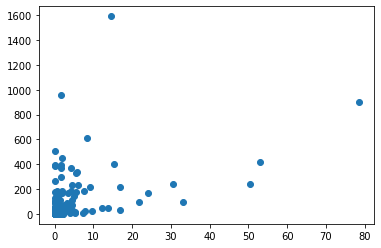

In [51]:
plt.scatter(current_day['built_percent_of_land_area'],current_day['cases_per_100k'])

In [52]:
bins = list(current_day['pop_percentage_over_65'].quantile([0, 0.2, 0.4, 0.6,0.7,0.9, 1]))

m2 = folium.Map(location=[48, -102], zoom_start=3)
folium.Choropleth(
    geo_data=country_geo,
    name='age',
    data=present_day,
    columns=[current_day.index,'pop_percentage_over_65'],
    key_on='properties.iso_a3',
    fill_color='OrRd',
    fill_opacity=0.5,
    line_opacity=0.2,
    bins=bins,
    legend_name='pop_percentage_over_65',
    show = False
).add_to(m2)


In [53]:
bins = list(current_day['trust_in_politicians'].quantile([0, 0.2, 0.4, 0.6,0.7,0.9, 1]))

#m2 = folium.Map(location=[48, -102], zoom_start=3)
folium.Choropleth(
    geo_data=country_geo,
    name='trust_in_politicians',
    data=present_day,
    columns=[current_day.index,'trust_in_politicians'],
    key_on='properties.iso_a3',
    fill_color='OrRd',
    fill_opacity=0.5,
    line_opacity=0.2,
    bins=bins,
    legend_name='trust_in_politicians',
    show = False
).add_to(m2)

In [54]:
bins = list(current_day['cases_per_100k'].quantile([0, 0.2, 0.4, 0.6,0.7,0.9, 1]))

#m2 = folium.Map(location=[48, -102], zoom_start=3)
folium.Choropleth(
    geo_data=country_geo,
    name='cases_per_100k',
    data=present_day,
    columns=[current_day.index,'cases_per_100k'],
    key_on='properties.iso_a3',
    fill_color='OrRd',
    fill_opacity=0.5,
    line_opacity=0.2,
    bins=bins,
    legend_name='cases_per_100k'
).add_to(m2)
folium.LayerControl().add_to(m2)

In [55]:
m2

In [56]:
m2.save("../Final project/website/folium/map2.html")

In [58]:
from bokeh.io import output_file, show, output_notebook
from bokeh.models import ColumnDataSource
from bokeh.models import FactorRange
from bokeh.plotting import figure
from bokeh.models import Legend

output_notebook() # for outputting to notebook
source = ColumnDataSource(current_day) # data importing
colors = ["#a83232", "#a86932"] #, "#a8a232", "#7da832", "#32a83c", "#32a87f", "#3283a8","#324aa8", "#5d32a8", "#9432a8", "#a83273", "#a83248", "#b59399", "#2e292a"]
data_to_show = ['cases_per_100k','pop_percentage_over_65_per_100k']

c = current_day.index.values.tolist()
countries=[]
for country in c:
    country =str(country)
    if country != 'nan':
        countries.append(country)
#countries = [str(country) for country in countries]
print(countries)
#countries.dtype()
#for i in range(24):
 #   hours.append(str(i))

p = figure(x_range = FactorRange(factors=countries), plot_height=400, plot_width=900, title="Countries and cases", 
           toolbar_location=None)
items=[]
bar ={} # to store vbars

for indx,i in enumerate(data_to_show):
    
    bar[i] = p.vbar(x='countryterritoryCode', top =i,  source= source, visible = True, width= 0.8, color =colors[indx], fill_alpha =0.6) 
    items.append((i, [bar[i]]))
    
#p.legend.click_policy="hide" ### assigns the click policy (you can try to use ''hide'
#p.legend.location = 'top_left'

legend = Legend(items=items, location=(0,0))
legend.click_policy="hide"

p.add_layout(legend, 'left')
p.xaxis.axis_label = "Country"
p.yaxis.axis_label = "Total Cases"

#bar['TRESPASS'].visible = True #we start with weapons laws just to display something

show(p) #displays your plot


Loading BokehJS ...

['AFG', 'ALB', 'DZA', 'AND', 'AGO', 'ATG', 'ARG', 'ARM', 'ABW', 'AUS', 'AUT', 'AZE', 'BHS', 'BHR', 'BGD', 'BRB', 'BLR', 'BEL', 'BLZ', 'BEN', 'BMU', 'BTN', 'BOL', 'BIH', 'BWA', 'BRA', 'VGB', 'BRN', 'BGR', 'BFA', 'BDI', 'KHM', 'CMR', 'CAN', 'CPV', 'CYM', 'CAF', 'TCD', 'CHL', 'CHN', 'COL', 'COG', 'CRI', 'CIV', 'HRV', 'CUB', 'CUW', 'CYP', 'CZE', 'COD', 'DNK', 'DJI', 'DMA', 'DOM', 'ECU', 'EGY', 'SLV', 'GNQ', 'ERI', 'EST', 'SWZ', 'ETH', 'FRO', 'FJI', 'FIN', 'FRA', 'PYF', 'GAB', 'GMB', 'GEO', 'DEU', 'GHA', 'GIB', 'GRC', 'GRL', 'GRD', 'GUM', 'GTM', 'GGY', 'GIN', 'GNB', 'GUY', 'HTI', 'VAT', 'HND', 'HUN', 'ISL', 'IND', 'IDN', 'IRN', 'IRQ', 'IRL', 'IMN', 'ISR', 'ITA', 'JAM', 'JPN', 'JEY', 'JOR', 'KAZ', 'KEN', 'XKX', 'KWT', 'KGZ', 'LAO', 'LVA', 'LBN', 'LBR', 'LBY', 'LIE', 'LTU', 'LUX', 'MDG', 'MWI', 'MYS', 'MDV', 'MLI', 'MLT', 'MRT', 'MUS', 'MEX', 'MDA', 'MCO', 'MNG', 'MNE', 'MSR', 'MAR', 'MOZ', 'MMR', 'NAM', 'NPL', 'NLD', 'NCL', 'NZL', 'NIC', 'NER', 'NGA', 'MKD', 'MNP', 'NOR', 'OMN', 'PAK', 'PSE'